In [1]:
import abc
import cv2
import math
import numpy as np
from FloorplanToBlenderLib import *
# from  import detect
# from *`` import transform
# from *`` import IO
# from *`` import const
# from *`` import draw
# from *`` import calculate

"""
Generator
This file contains structures for different floorplan detection features.

FloorplanToBlender3d
Copyright (C) 2022 Daniel Westberg
"""


class Generator:
    __metaclass__ = abc.ABCMeta
    # create verts (points 3d), points to use in mesh creations
    verts = []
    # create faces for each plane, describe order to create mesh points
    faces = []
    # Height of waLL
    height = const.WALL_HEIGHT
    # Scale pixel value to 3d pos
    pixelscale = const.PIXEL_TO_3D_SCALE
    # Object scale
    scale = np.array([1, 1, 1])
    # Index is many for when there are several floorplans
    path = ""

    def __init__(self, gray, path, scale, info=False):
        self.path = path
        self.shape = self.generate(gray, info)
        self.scale = scale

    def get_shape(self, verts):
        """
        Get shape
        Rescale boxes to specified scale
        @Param verts, input boxes
        @Param scale to use
        @Return rescaled boxes
        """
        if len(verts) == 0:
            return [0, 0, 0]

        poslist = transform.verts_to_poslist(verts)
        high = [0, 0, 0]
        low = poslist[0]

        for pos in poslist:
            if pos[0] > high[0]:
                high[0] = pos[0]
            if pos[1] > high[1]:
                high[1] = pos[1]
            if pos[2] > high[2]:
                high[2] = pos[2]
            if pos[0] < low[0]:
                low[0] = pos[0]
            if pos[1] < low[1]:
                low[1] = pos[1]
            if pos[2] < low[2]:
                low[2] = pos[2]

        return [
            (high[0] - low[0]) * self.scale[0],
            (high[1] - low[1]) * self.scale[1],
            (high[2] - low[2]) ** self.scale[2],
        ]

    @abc.abstractmethod
    def generate(self, gray, info=False):
        """Perform the generation"""
        pass


class Floor(Generator):
    def __init__(self, gray, path, scale, info=False):
        super().__init__(gray, path, scale, info)

    def generate(self, gray, info=False):

        # detect outer Contours (simple floor or roof solution)
        contour, _ = detect.outer_contours(gray)
        # Create verts
        self.verts = transform.scale_point_to_vector(
            boxes=contour,
            scale=self.scale,
            pixelscale=self.pixelscale,
            height=self.height,
        )

        # create faces
        count = 0
        for _ in self.verts:
            self.faces.extend([(count)])
            count += 1

        if info:
            print("Approximated apartment size : ", cv2.contourArea(contour))

        IO.save_to_file(self.path + const.FLOOR_VERTS, self.verts, info)
        IO.save_to_file(self.path + const.FLOOR_FACES, self.faces, info)

        return self.get_shape(self.verts)


class Wall(Generator):
    def __init__(self, gray, path, scale, info=False):
        super().__init__(gray, path, scale, info)

    def generate(self, gray, info=False):

        # create wall image (filter out small objects from image)
        wall_img = detect.wall_filter(gray)

        # detect walls
        boxes, _ = detect.precise_boxes(wall_img)

        # detect contour
        contour, _ = detect.outer_contours(gray)

        # remove walls outside of contour
        boxes = calculate.remove_walls_not_in_contour(boxes, contour)
        # Convert boxes to verts and faces, vertically
        self.verts, self.faces, wall_amount = transform.create_nx4_verts_and_faces(
            boxes=boxes,
            height=self.height,
            scale=self.scale,
            pixelscale=self.pixelscale,
        )

        if info:
            print("Walls created : ", wall_amount)

        # One solution to get data to blender is to write and read from file.
        IO.save_to_file(self.path + const.WALL_VERTICAL_VERTS, self.verts, info)
        IO.save_to_file(self.path + const.WALL_VERTICAL_FACES, self.faces, info)

        # Same but horizontally
        self.verts, self.faces, wall_amount = transform.create_4xn_verts_and_faces(
            boxes=boxes,
            height=self.height,
            scale=self.scale,
            pixelscale=self.pixelscale,
            ground=True,
        )

        # One solution to get data to blender is to write and read from file.
        IO.save_to_file(self.path + const.WALL_HORIZONTAL_VERTS, self.verts, info)
        IO.save_to_file(self.path + const.WALL_HORIZONTAL_FACES, self.faces, info)

        return self.get_shape(self.verts)


class Room(Generator):
    def __init__(self, gray, path, scale, info=False):
        self.height = (
            const.WALL_HEIGHT - const.ROOM_FLOOR_DISTANCE
        )  # place room slightly above floor
        super().__init__(gray, path, scale, info)

    def generate(self, gray, info=False):
        gray = detect.wall_filter(gray)
        gray = ~gray
        rooms, colored_rooms = detect.find_rooms(gray.copy())
        gray_rooms = cv2.cvtColor(colored_rooms, cv2.COLOR_BGR2GRAY)

        # get box positions for rooms
        boxes, gray_rooms = detect.precise_boxes(gray_rooms, gray_rooms)

        self.verts, self.faces, counter = transform.create_4xn_verts_and_faces(
            boxes=boxes,
            height=self.height,
            scale=self.scale,
            pixelscale=self.pixelscale,
        )

        if info:
            print("Number of rooms detected : ", counter)

        IO.save_to_file(self.path + const.ROOM_VERTS, self.verts, info)
        IO.save_to_file(self.path + const.ROOM_FACES, self.faces, info)

        return self.get_shape(self.verts)


class Door(Generator):
    def __init__(self, gray, path, image_path, scale_factor, scale, info=False):
        self.image_path = image_path
        self.scale_factor = scale_factor
        super().__init__(gray, path, scale, info)

    def get_point_the_furthest_away(self, door_features, door_box):
        """
        Calculate door point furthest away from doorway
        """
        best_point = None
        dist = 0
        center = calculate.box_center(door_box)
        for f in door_features:
            if best_point is None:
                best_point = f
                dist = abs(calculate.euclidean_distance_2d(center, f))
            else:
                distance = abs(calculate.euclidean_distance_2d(center, f))
                if dist < distance:
                    best_point = f
                    dist = distance
        return best_point

    def get_closest_box_point_to_door_point(self, wall_point, box):
        """
        Calculate best point in box to anchor door
        """
        best_point = None
        dist = math.inf

        box_side_points = []
        (x, y, w, h) = cv2.boundingRect(box)

        if w < h:
            box_side_points = [[x + w / 2, y], [x + w / 2, y + h]]
        else:
            box_side_points = [[x, y + h / 2], [x + w, y + h / 2]]

        for fp in box_side_points:
            if best_point is None:
                best_point = fp
                dist = calculate.euclidean_distance_2d(wall_point, fp)
            else:
                distance = calculate.euclidean_distance_2d(wall_point, fp)
                if distance > dist:
                    best_point = fp
                    dist = distance
        return (int(best_point[0]), int(best_point[1]))

    def generate(self, gray, info=False):

        doors = detect.doors(self.image_path, self.scale_factor)

        door_contours = []
        # get best door shapes!
        for door in doors:
            door_features = door[0]
            door_box = door[1]

            # find door to space point
            space_point = self.get_point_the_furthest_away(door_features, door_box)

            # find best box corner to use as attachment
            closest_box_point = self.get_closest_box_point_to_door_point(
                space_point, door_box
            )

            # Calculate normal
            normal_line = [
                space_point[0] - closest_box_point[0],
                space_point[1] - closest_box_point[1],
            ]

            # Normalize point
            normal_line = calculate.normalize_2d(normal_line)

            # Create door contour
            x1 = closest_box_point[0] + normal_line[1] * const.DOOR_WIDTH
            y1 = closest_box_point[1] - normal_line[0] * const.DOOR_WIDTH

            x2 = closest_box_point[0] - normal_line[1] * const.DOOR_WIDTH
            y2 = closest_box_point[1] + normal_line[0] * const.DOOR_WIDTH

            x4 = space_point[0] + normal_line[1] * const.DOOR_WIDTH
            y4 = space_point[1] - normal_line[0] * const.DOOR_WIDTH

            x3 = space_point[0] - normal_line[1] * const.DOOR_WIDTH
            y3 = space_point[1] + normal_line[0] * const.DOOR_WIDTH

            c1 = [int(x1), int(y1)]
            c2 = [int(x2), int(y2)]
            c3 = [int(x3), int(y3)]
            c4 = [int(x4), int(y4)]

            door_contour = np.array([[c1], [c2], [c3], [c4]], dtype=np.int32)
            door_contours.append(door_contour)

        if const.DEBUG_DOOR:
            print("Showing DEBUG door. Press any key to continue...")
            img = draw.contoursOnImage(gray, door_contours)
            draw.image(img)

        # Create verts for door

        self.verts, self.faces, door_amount = transform.create_nx4_verts_and_faces(
            boxes=door_contours,
            height=self.height,
            scale=self.scale,
            pixelscale=self.pixelscale,
        )

        if info:
            print("Doors created : ", int(door_amount / 4))

        IO.save_to_file(self.path + "door_vertical_verts", self.verts, info)
        IO.save_to_file(self.path + "door_vertical_faces", self.faces, info)

        self.verts, self.faces, door_amount = transform.create_4xn_verts_and_faces(
            boxes=door_contours,
            height=self.height,
            scale=self.scale,
            pixelscale=self.pixelscale,
            ground=True,
            ground_height=const.WALL_GROUND,
        )

        # One solution to get data to blender is to write and read from file.
        IO.save_to_file(self.path + "door_horizontal_verts", self.verts, info)
        IO.save_to_file(self.path + "door_horizontal_faces", self.faces, info)

        return self.get_shape(self.verts)


class Window(Generator):
    # TODO: also fill small gaps between windows and walls
    # TODO: also add verts for filling gaps

    def __init__(self, gray, path, image_path, scale_factor, scale, info=False):
        self.image_path = image_path
        self.scale_factor = scale_factor
        self.scale = scale
        super().__init__(gray, path, scale, info)

    def generate(self, gray, info=False):
        windows = detect.windows(self.image_path, self.scale_factor)

        # Create verts for window, vertical
        v, self.faces, window_amount1 = transform.create_nx4_verts_and_faces(
            boxes=windows,
            height=const.WINDOW_MIN_MAX_GAP[0],
            scale=self.scale,
            pixelscale=self.pixelscale,
            ground=0,
        )  # create low piece
        v2, self.faces, window_amount2 = transform.create_nx4_verts_and_faces(
            boxes=windows,
            height=self.height,
            scale=self.scale,
            pixelscale=self.pixelscale,
            ground=const.WINDOW_MIN_MAX_GAP[1],
        )  # create higher piece

        self.verts = v
        self.verts.extend(v2)
        parts_per_window = 2
        window_amount = len(v) / parts_per_window

        if info:
            print("Windows created : ", int(window_amount))

        IO.save_to_file(self.path + const.WINDOW_VERTICAL_VERTS, self.verts, info)
        IO.save_to_file(self.path + const.WINDOW_VERTICAL_FACES, self.faces, info)

        # horizontal

        v, f, _ = transform.create_4xn_verts_and_faces(
            boxes=windows,
            height=self.height,
            scale=self.scale,
            pixelscale=self.pixelscale,
            ground=True,
            ground_height=const.WALL_GROUND,
        )
        v2, f2, _ = transform.create_4xn_verts_and_faces(
            boxes=windows,
            height=const.WINDOW_MIN_MAX_GAP[0],
            scale=self.scale,
            pixelscale=self.pixelscale,
            ground=True,
            ground_height=const.WINDOW_MIN_MAX_GAP[1],
        )

        self.verts = v
        self.verts.extend(v2)
        self.faces = f
        self.faces.extend(f2)

        # One solution to get data to blender is to write and read from file.
        IO.save_to_file(self.path + const.WINDOW_HORIZONTAL_VERTS, self.verts, info)
        IO.save_to_file(self.path + const.WINDOW_HORIZONTAL_FACES, self.faces, info)

        return self.get_shape(self.verts)


In [70]:
import pandas as pd
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt

In [3]:
img = cv2.imread("D:/FloorplanToBlender3d-master/Images/Examples/Bedroom.png")


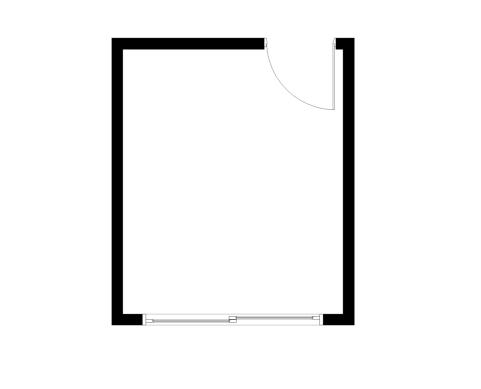

In [4]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [5]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
height, width, channels = img.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


-1

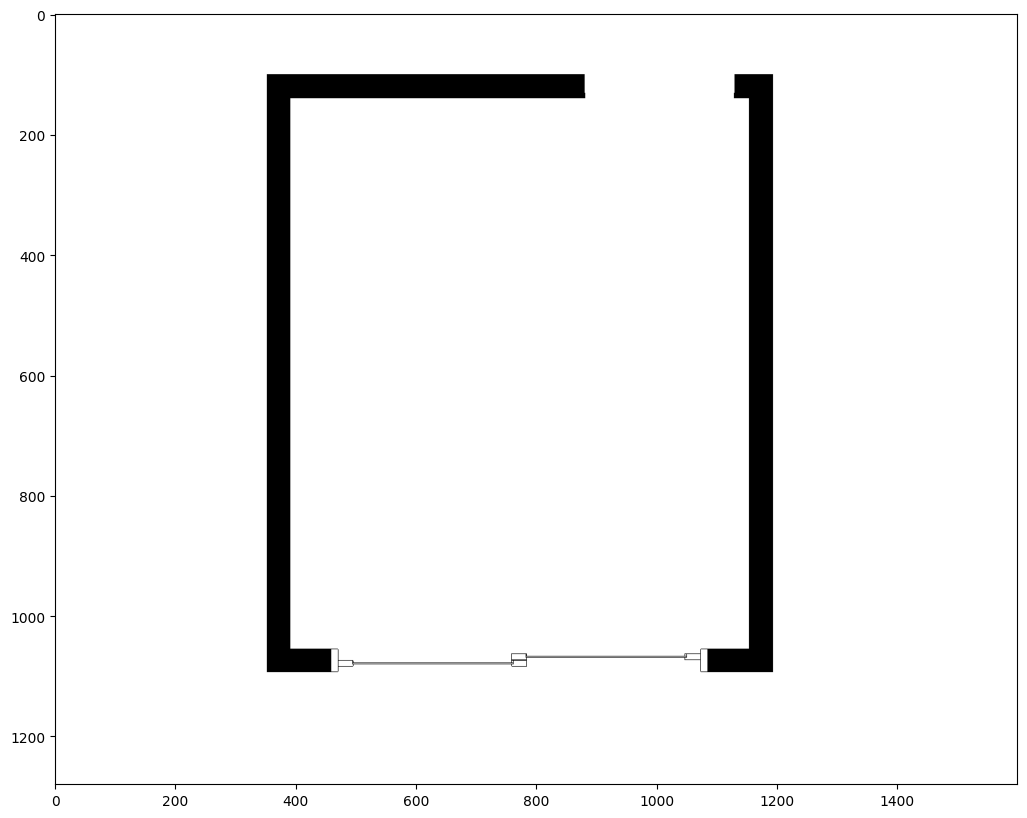

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os


img = cv2.imread("D:/FloorplanToBlender3d-master/Images/Examples/Bedroom.png")

img_bw = 255 * (cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) > 20).astype("uint8")

se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
mask = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, se1)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)

mask = np.dstack([mask, mask, mask]) / 255
out = img * mask
plt.figure(figsize=(15, 10))
plt.imshow(out, cmap="gray")
cv2.imshow("test", out)
cv2.waitKey(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


-1

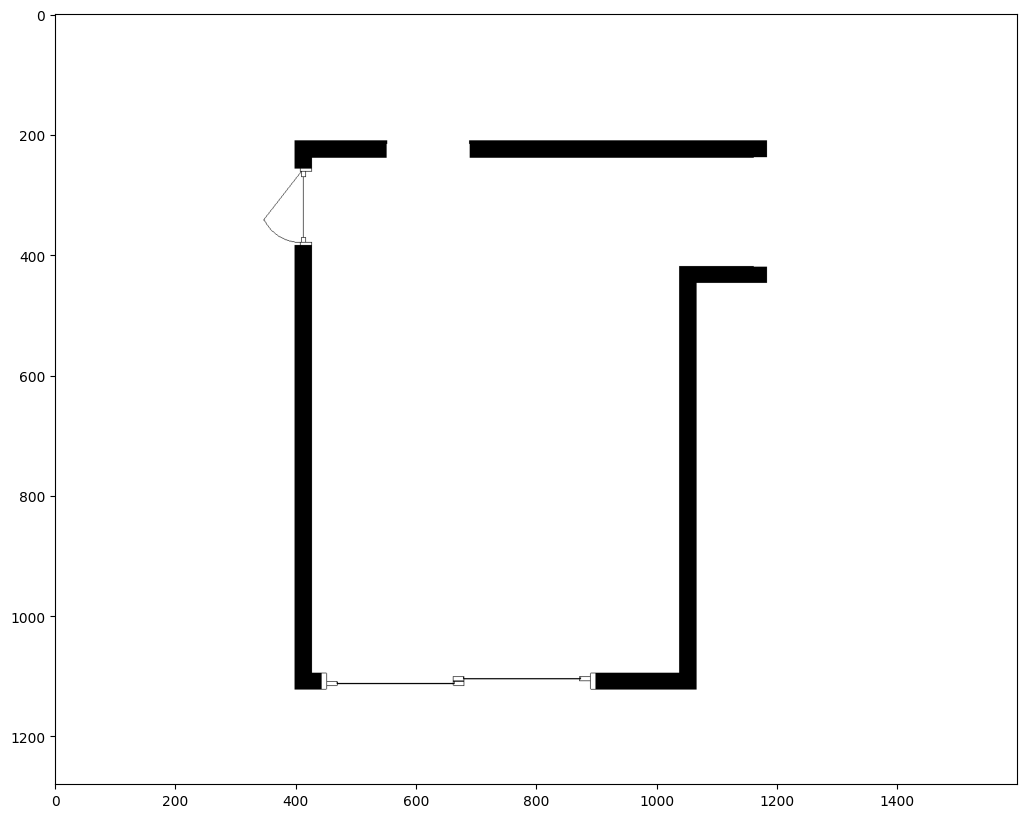

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os


img = cv2.imread("D:/FloorplanToBlender3d-master/Images/Examples/masterbd.png")

img_bw = 255 * (cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) > 20).astype("uint8")

se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
mask = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, se1)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)

mask = np.dstack([mask, mask, mask]) / 255
out = img * mask
plt.figure(figsize=(15, 10))
plt.imshow(out, cmap="gray")
cv2.imshow("test", out)
cv2.waitKey(0)

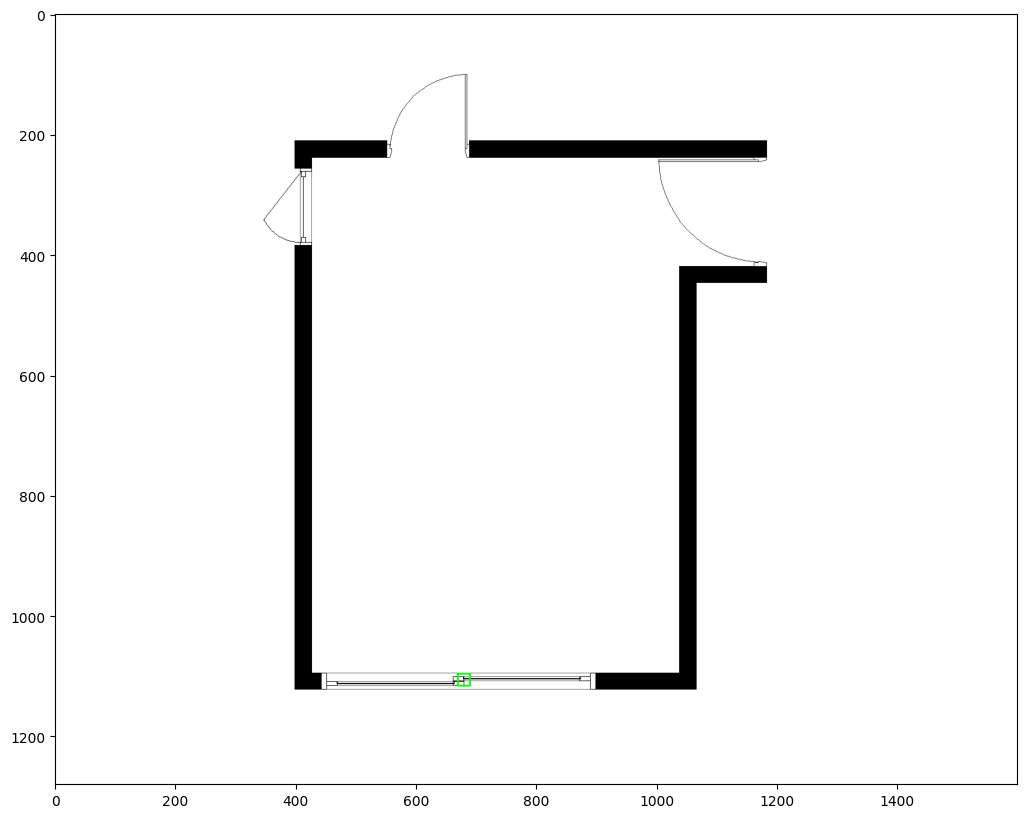

In [8]:
img = cv2.imread("D:/FloorplanToBlender3d-master/Images/Examples/masterbd.png")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray, 1000, 0.99999, 50)

for corner in corners:
    x, y = corner[0]
    x = int(x)
    y = int(y)
    cv2.rectangle(img, (x - 10, y - 10), (x + 10, y + 10), (0, 255, 0), 2)

cv2.imshow("Corners Found", img)
cv2.waitKey()
plt.figure(figsize=(15, 10))
plt.imshow(img, cmap="gray")
cv2.destroyAllWindows()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-765.0..1020.0].


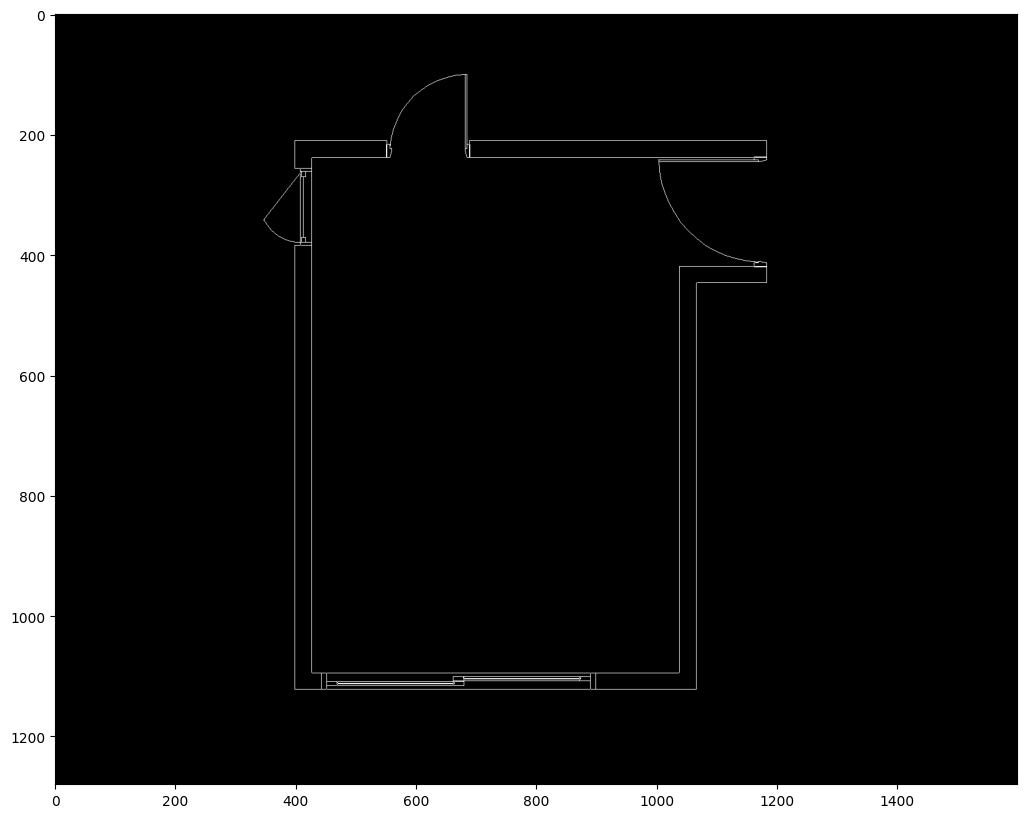

In [9]:
img = cv2.imread("D:/FloorplanToBlender3d-master/Images/Examples/masterbd.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gaussian = cv2.GaussianBlur(gray, (3, 3), 0)

# canny
img_canny = cv2.Canny(img, 100, 200)

# sobel
img_sobelx = cv2.Sobel(img_gaussian, cv2.CV_8U, 1, 0, ksize=5)
img_sobely = cv2.Sobel(img_gaussian, cv2.CV_8U, 0, 1, ksize=5)
img_sobel = img_sobelx + img_sobely

# prewitt
kernelx = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
kernely = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
img_prewittx = cv2.filter2D(img_gaussian, -1, kernelx)
img_prewitty = cv2.filter2D(img_gaussian, -1, kernely)
laplacian = cv2.Laplacian(img, cv2.CV_64F)

cv2.imshow("Original Image", img)
cv2.imshow("Canny", img_canny)  # appears to be best
#cv2.imshow("Sobel X", img_sobelx)
#cv2.imshow("Sobel Y", img_sobely)
cv2.imshow("Sobel", img_sobel)
#cv2.imshow("Prewitt X", img_prewittx)
#cv2.imshow("Prewitt Y", img_prewitty)
cv2.imshow("Prewitt", img_prewittx + img_prewitty)
cv2.imshow("laplacian", laplacian) 


plt.figure(figsize=(15, 10))
plt.imshow(img_canny, cmap="gray")
plt.imshow(img_sobelx, cmap="gray")
plt.imshow(img_sobely, cmap="gray")
plt.imshow(img_sobel, cmap="gray")
plt.imshow(img_prewittx, cmap="gray")
plt.imshow(img_prewitty, cmap="gray")
plt.imshow(img_gaussian, cmap="gray")
plt.imshow(laplacian, cmap="gray")


cv2.waitKey(0)
cv2.destroyAllWindows()

In [10]:
#WALL_FUNCTIONS

In [11]:
WALL_FILTER_TRESHOLD=[0, 255]
WALL_FILTER_KERNEL_SIZE = (3, 3)
WALL_FILTER_MORPHOLOGY_ITERATIONS = 2
WALL_FILTER_DILATE_ITERATIONS = 3
WALL_FILTER_DISTANCE = 5
WALL_FILTER_DISTANCE_THRESHOLD = [0.5, 0.2]
WALL_FILTER_MAX_VALUE = 255
WALL_FILTER_THRESHOLD_TECHNIQUE = 0

PRECISE_BOXES_ACCURACY = 0.001

OUTER_CONTOURS_TRESHOLD = [230, 255]


In [12]:
gray

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [13]:
def wall_filter(gray):
    """
    Filter walls
    Filter out walls from a grayscale image
    @Param image
    @Return image of walls
    """
    _, thresh = cv2.threshold(
        gray,
        WALL_FILTER_TRESHOLD[0],
        WALL_FILTER_TRESHOLD[1],
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU,
    )

    # noise removal
    kernel = np.ones(WALL_FILTER_KERNEL_SIZE, np.uint8)
    opening = cv2.morphologyEx(
        thresh,
        cv2.MORPH_OPEN,
        kernel,
        iterations=WALL_FILTER_MORPHOLOGY_ITERATIONS,
    )

    sure_bg = cv2.dilate(
        opening, kernel, iterations=WALL_FILTER_DILATE_ITERATIONS
    )

    dist_transform = cv2.distanceTransform(
        opening, cv2.DIST_L2,WALL_FILTER_DISTANCE
    )
    ret, sure_fg = cv2.threshold(
        WALL_FILTER_DISTANCE_THRESHOLD[0] * dist_transform,
        WALL_FILTER_DISTANCE_THRESHOLD[1] * dist_transform.max(),
        WALL_FILTER_MAX_VALUE,
        WALL_FILTER_THRESHOLD_TECHNIQUE,
    )

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    plt.imshow(unknown)
    print(unknown)

    return unknown



[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


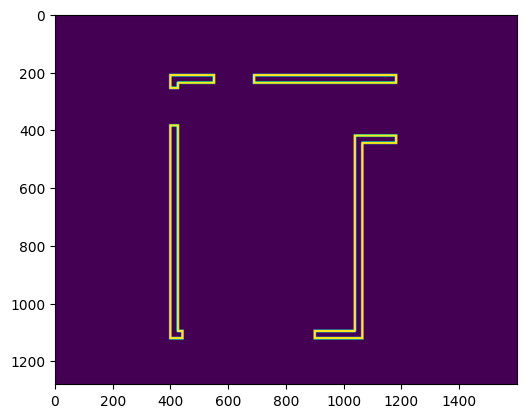

In [14]:
wall_img=wall_filter(gray)

In [15]:
def precise_boxes(detect_img, output_img=None, color=[100, 100, 0]):
    """
    Detect corners with boxes in image with high precision
    @Param detect_img image to detect from @mandatory
    @Param output_img image for output
    @Param color to set on output
    @Return corners(list of boxes), output image
    @source https://stackoverflow.com/questions/50930033/drawing-lines-and-distance-to-them-on-image-opencv-python
    """
    res = []

    contours, _ = cv2.findContours(
        detect_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    for cnt in contours:
        epsilon = PRECISE_BOXES_ACCURACY * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        if output_img is not None:
            output_img = cv2.drawContours(output_img, [approx], 0, color)
        res.append(approx)
        
        

    return res, output_img

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


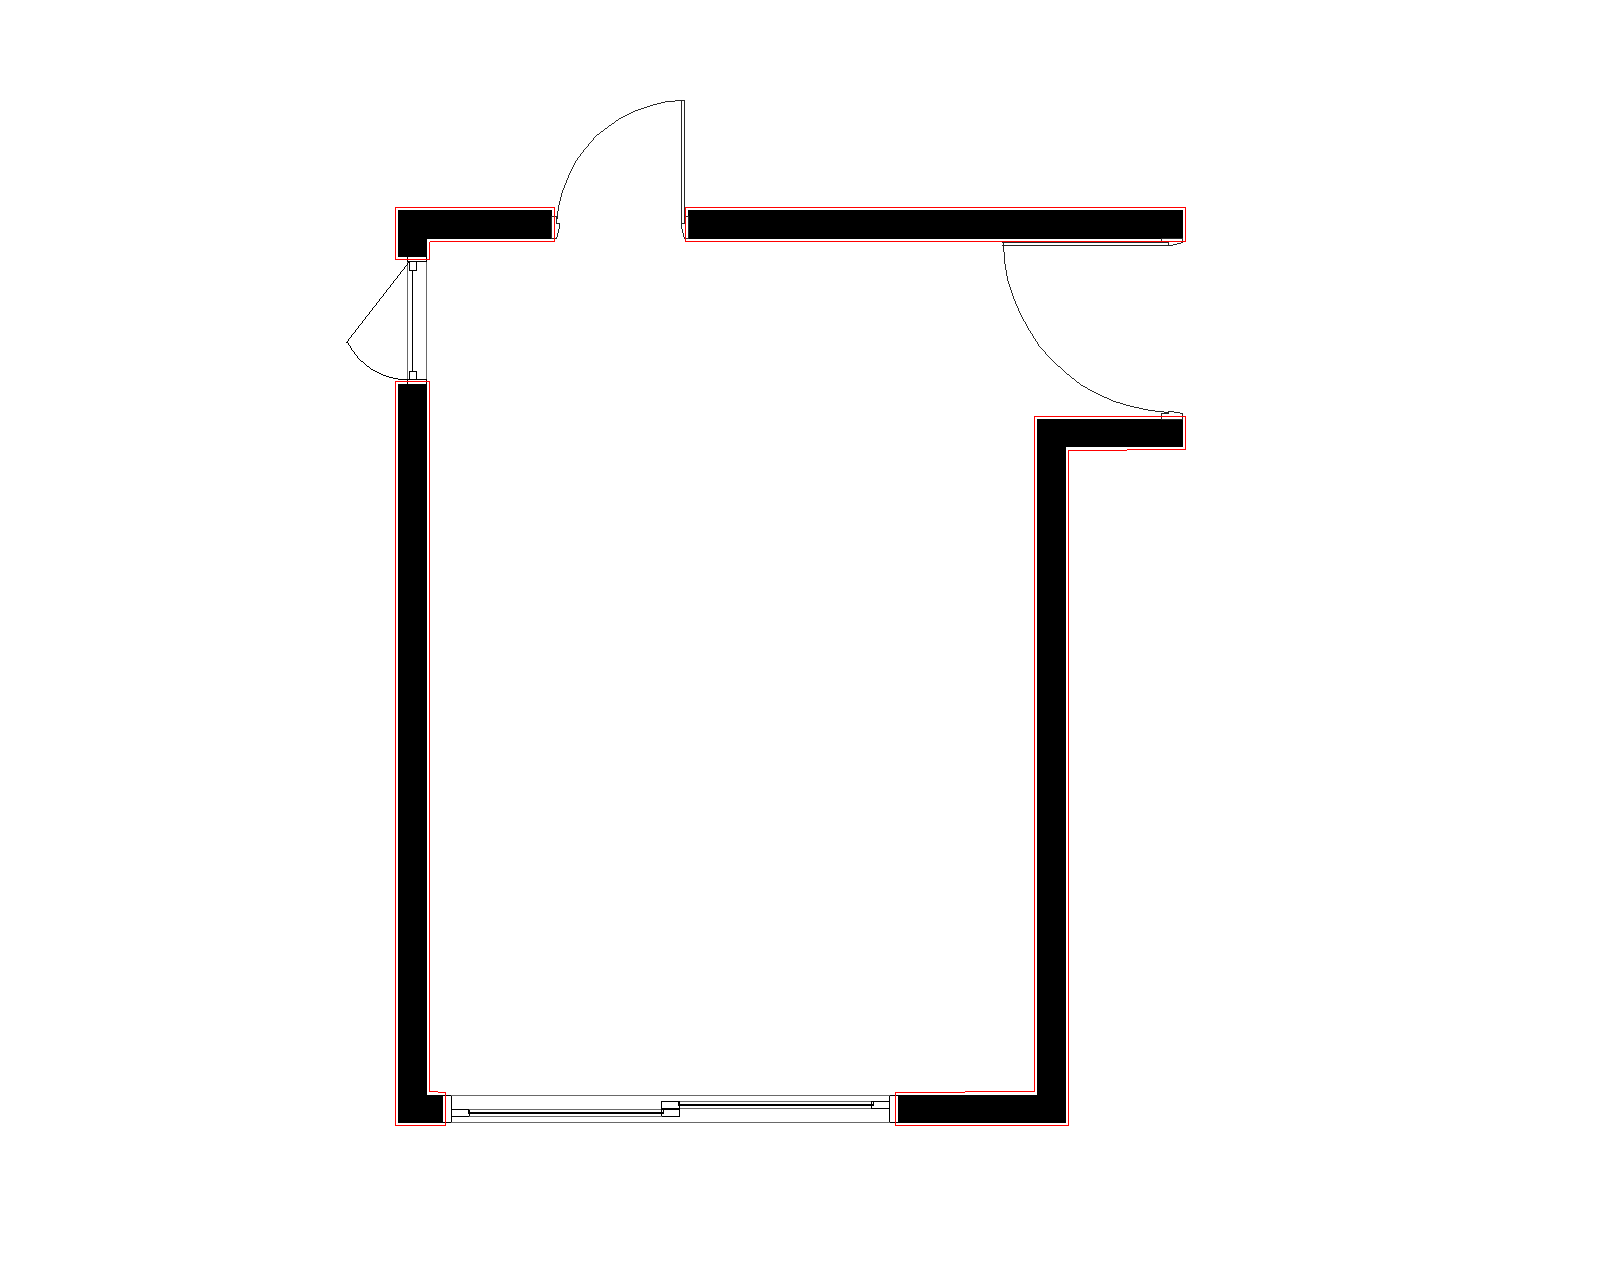

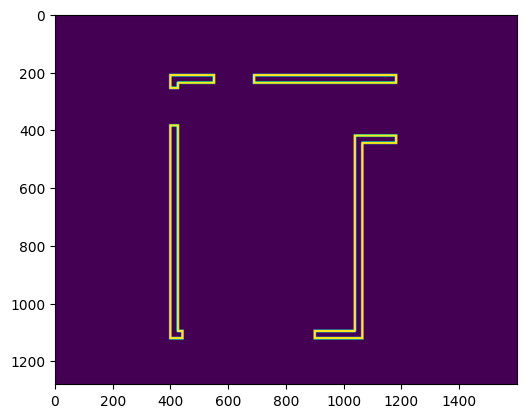

In [16]:
from PIL import Image
from IPython.display import display


# Create new blank image
blank_image = img.copy()

# Perform filter on grayscaled input image
wall_img = wall_filter(gray)

"""
Detect Wall
"""
boxes, w_img = precise_boxes(wall_img, blank_image, color=[255,0,0])

# Display
display(Image.fromarray(blank_image))

In [17]:
def outer_contours(detect_img, output_img=None, color=[255, 255, 255]):
    """
    Get the outer side of floorplan, used to get ground
    @Param detect_img image to detect from @mandatory
    @Param output_img image for output
    @Param color to set on output
    @Return approx, box
    @Source https://stackoverflow.com/questions/50930033/drawing-lines-and-distance-to-them-on-image-opencv-python
    """
    ret, thresh = cv2.threshold(
        detect_img,
        OUTER_CONTOURS_TRESHOLD[0],
        OUTER_CONTOURS_TRESHOLD[1],
        cv2.THRESH_BINARY_INV,
    )

    contours, hierarchy = cv2.findContours(
        thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    largest_contour_area = 0
    for cnt in contours:
        if cv2.contourArea(cnt) > largest_contour_area:
            largest_contour_area = cv2.contourArea(cnt)
            largest_contour = cnt

    epsilon = PRECISE_BOXES_ACCURACY * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)
    if output_img is not None:
        output_img = cv2.drawContours(output_img, [approx], 0, color)
        print(type(output_img))
        display(Image.fromarray(output_img))
    return approx, output_img


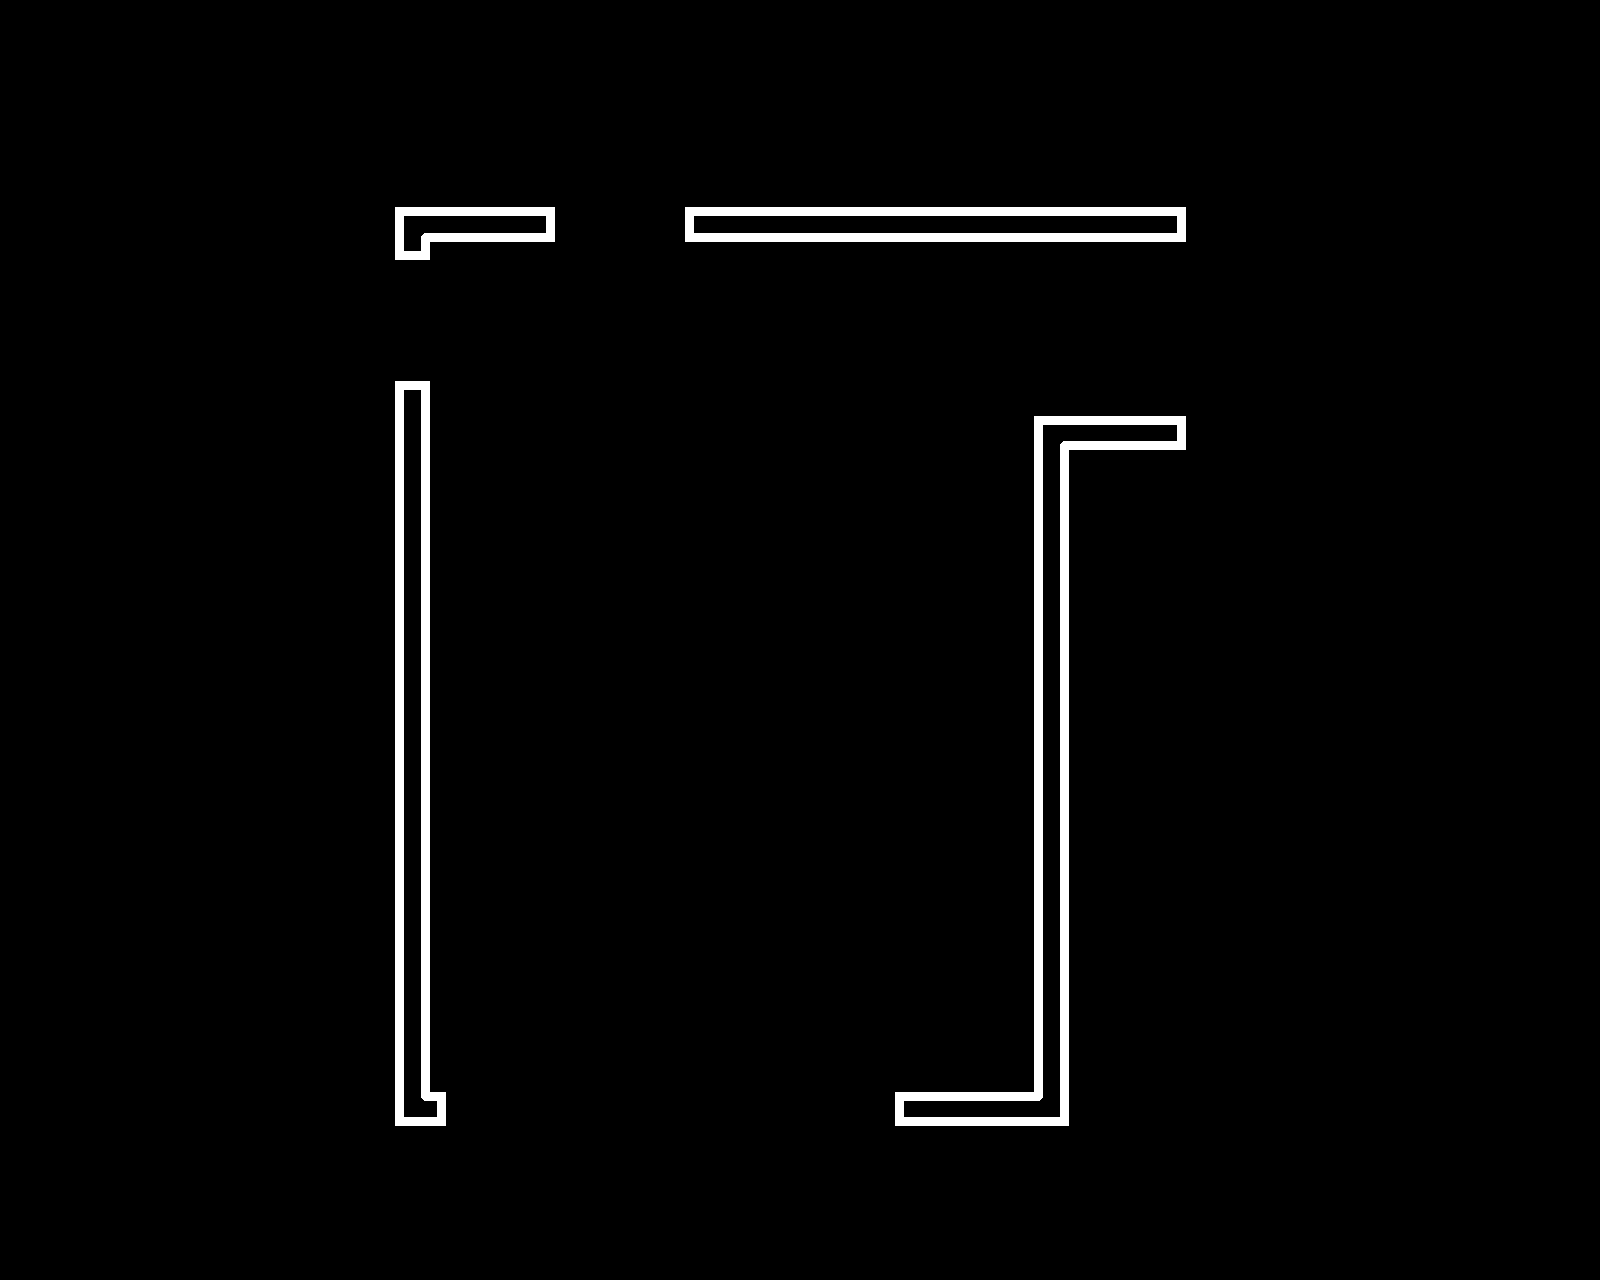

In [18]:
contour, _ = outer_contours(wall_img)
display(Image.fromarray(wall_img))

In [19]:
def points_inside_contour(points, contour):
    """
    Return false if all of the points are outside of the contour
    """
    
    for x, y in points:
        if cv2.pointPolygonTest(contour, (float(x),float(y)), False) == 1.0:
            return True
    return False


In [20]:
def remove_walls_not_in_contour(walls, contour):
    """
    Returns a list of boxes where walls outside of contour is removed.
    """
    res = []
    for wall in walls:
        for point in wall:
            if points_inside_contour(point, contour):
                res.append(wall)
                break
    return res


In [21]:
boxes = remove_walls_not_in_contour(boxes, contour)

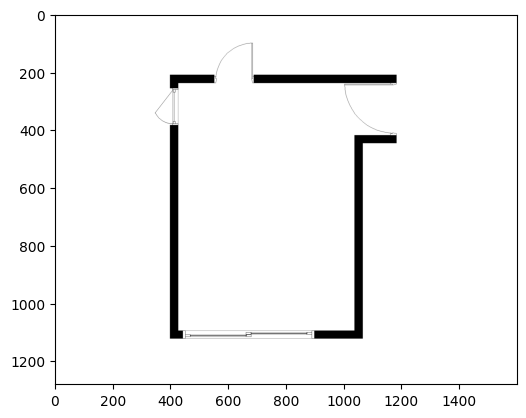

In [22]:
plt.imshow(img)

In [23]:
class Wall(Generator):
    def __init__(self, gray, path, scale, info=False):
        super().__init__(gray, path, scale, info)

    def generate(self, gray, info=False):

        # create wall image (filter out small objects from image)
        wall_img = wall_filter(gray)

        # detect walls
        boxes, _ = precise_boxes(wall_img)

        # detect contour
        contour, _ = outer_contours(gray)

        # remove walls outside of contour
        boxes = calculate.remove_walls_not_in_contour(boxes, contour)
        # Convert boxes to verts and faces, vertically
        self.verts, self.faces, wall_amount = transform.create_nx4_verts_and_faces(
            boxes=boxes,
            height=self.height,
            scale=self.scale,
            pixelscale=self.pixelscale,
        )

        if info:
            print("Walls created : ", wall_amount)

        # One solution to get data to blender is to write and read from file.
        IO.save_to_file(self.path + const.WALL_VERTICAL_VERTS, self.verts, info)
        IO.save_to_file(self.path + const.WALL_VERTICAL_FACES, self.faces, info)

        # Same but horizontally
        self.verts, self.faces, wall_amount = transform.create_4xn_verts_and_faces(
            boxes=boxes,
            height=self.height,
            scale=self.scale,
            pixelscale=self.pixelscale,
            ground=True,
        )

        # One solution to get data to blender is to write and read from file.
        IO.save_to_file(self.path + const.WALL_HORIZONTAL_VERTS, self.verts, info)
        IO.save_to_file(self.path + const.WALL_HORIZONTAL_FACES, self.faces, info)

        return self.get_shape(self.verts)

In [24]:
#ROOM_FUNCTIONS

In [25]:
OUTER_CONTOURS_TRESHOLD = [230, 255]
PRECISE_HARRIS_KERNEL_SIZE = (1, 1)
PRECISE_HARRIS_BLOCK_SIZE = 2
PRECISE_HARRIS_KSIZE = 3
PRECISE_HARRIS_K = 0.04
PRECISE_ERODE_ITERATIONS = 10


FIND_ROOMS_NOISE_REMOVAL_THRESHOLD = 50
FIND_ROOMS_CORNERS_THRESHOLD = 0.01
FIND_ROOMS_CLOSING_MAX_LENGTH = 130
FIND_ROOMS_GAP_IN_WALL_MIN_THRESHOLD = 5000


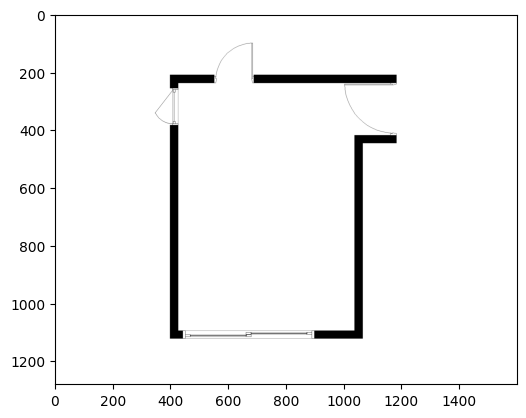

In [26]:
img=cv2.imread("D:/FloorplanToBlender3d-master/Images/Examples/masterbd.png")
plt.imshow(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [27]:
img=gray

In [28]:
def remove_noise(img, noise_removal_threshold):
    """
    Remove noise from image and return mask
    Help function for finding room
    @Param img @mandatory image to remove noise from
    @Param noise_removal_threshold @mandatory threshold for noise
    @Return return new mask of image
    """
    img[img < 128] = 0
    img[img > 128] = 255
    contours, _ = cv2.findContours(~img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(img)
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > noise_removal_threshold:
            cv2.fillPoly(mask, [contour], 255)
    return mask


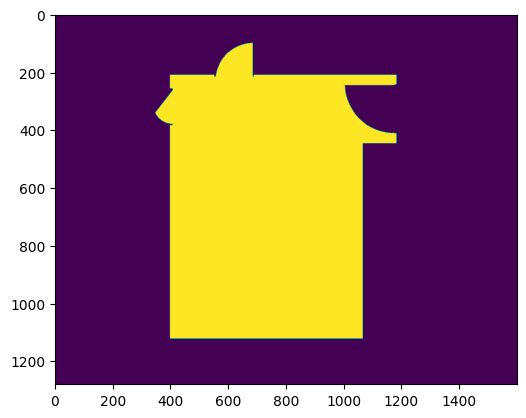

In [29]:
plt.imshow(remove_noise(img,noise_removal_threshold=50))

In [30]:
mask = remove_noise(img, noise_removal_threshold=50)
img = ~mask

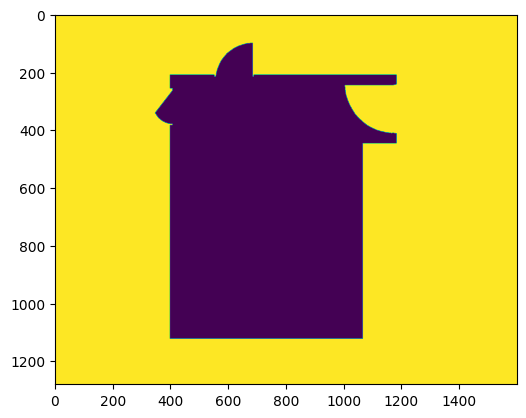

In [31]:
plt.imshow(img)

In [32]:
def corners_and_draw_lines(img, corners_threshold, room_closing_max_length):
    """
    Finds corners and draw lines from them
    Help function for finding room
    @Param image input image
    @Param corners_threshold threshold for corner distance
    @Param room_closing_max_length threshold for room max size
    @Return output image
    """
    # Detect corners (you can play with the parameters here)
    kernel = np.ones(PRECISE_HARRIS_KERNEL_SIZE, np.uint8)

    dst = cv2.cornerHarris(
        img,
        PRECISE_HARRIS_BLOCK_SIZE,
        PRECISE_HARRIS_KSIZE,
        PRECISE_HARRIS_K,
    )
    dst = cv2.erode(dst, kernel, iterations=PRECISE_ERODE_ITERATIONS)
    corners = dst > corners_threshold * dst.max()

    # Draw lines to close the rooms off by adding a line between corners on the same x or y coordinate
    # This gets some false positives.
    # You could try to disallow drawing through other existing lines for example.
    for y, row in enumerate(corners):
        x_same_y = np.argwhere(row)
        for x1, x2 in zip(x_same_y[:-1], x_same_y[1:]):

            if x2[0] - x1[0] < room_closing_max_length:
                color = 0
                cv2.line(img, (x1[0], y), (x2[0], y), color, 1)

    for x, col in enumerate(corners.T):
        y_same_x = np.argwhere(col)
        for y1, y2 in zip(y_same_x[:-1], y_same_x[1:]):
            if y2[0] - y1[0] < room_closing_max_length:
                color = 0
                cv2.line(img, (x, y1[0]), (x, y2[0]), color, 1)
    return img


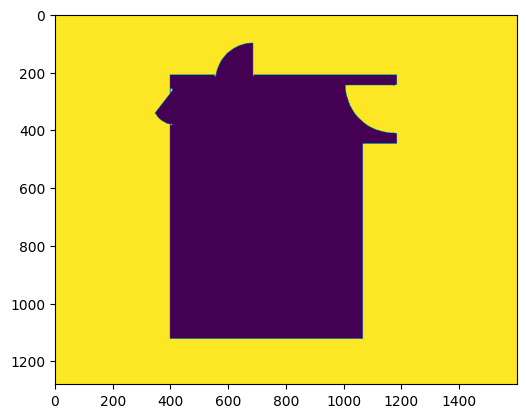

In [33]:
plt.imshow(corners_and_draw_lines(img,corners_threshold= 0.01,room_closing_max_length=130))

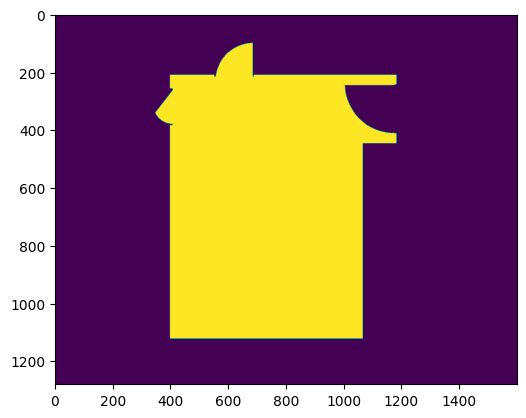

In [34]:
plt.imshow(mask)

In [35]:
def mark_outside_black(img, mask):
    """
    Mark white background as black
    @Param @mandatory img image input
    @Param @mandatory mask mask to use
    @Return image, mask
    """
    # Mark the outside of the house as black
    contours, _ = cv2.findContours(~img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]
    mask = np.zeros_like(mask)
    cv2.fillPoly(mask, [biggest_contour], 255)
    img[mask == 0] = 0
    return img, mask


In [36]:
# plt.imshow(img)

In [37]:
# plt.imshow(mark_outside_black(img,mask))

In [38]:
def find_rooms(
    img,
    noise_removal_threshold=FIND_ROOMS_NOISE_REMOVAL_THRESHOLD,
    corners_threshold=FIND_ROOMS_CORNERS_THRESHOLD,
    room_closing_max_length=FIND_ROOMS_CLOSING_MAX_LENGTH,
    gap_in_wall_min_threshold=FIND_ROOMS_GAP_IN_WALL_MIN_THRESHOLD,
):
    """
    src: https://stackoverflow.com/questions/54274610/crop-each-of-them-using-opencv-python

    @param img: grey scale image of rooms, already eroded and doors removed etc.
    @param noise_removal_threshold: Minimal area of blobs to be kept.
    @param corners_threshold: Threshold to allow corners. Higher removes more of the house.
    @param room_closing_max_length: Maximum line length to add to close off open doors.
    @param gap_in_wall_threshold: Minimum number of pixels to identify component as room instead of hole in the wall.
    @return: rooms: list of numpy arrays containing boolean masks for each detected room
             colored_house: A colored version of the input image, where each room has a random color.
    """
    assert 0 <= corners_threshold <= 1
    # Remove noise left from door removal

    mask = remove_noise(img, noise_removal_threshold)
    img = ~mask

    corners_and_draw_lines(img, corners_threshold, room_closing_max_length)

    img, mask = mark_outside_black(img, mask)
    

    # Find the connected components in the house
    ret, labels = cv2.connectedComponents(img)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    unique = np.unique(labels)
    rooms = []
    for label in unique:
        component = labels == label
        if (
            img[component].sum() == 0
            or np.count_nonzero(component) < gap_in_wall_min_threshold
        ):
            color = 0
        else:
            rooms.append(component)
            color = np.random.randint(0, 255, size=3)
        img[component] = color
    return rooms, img

[]


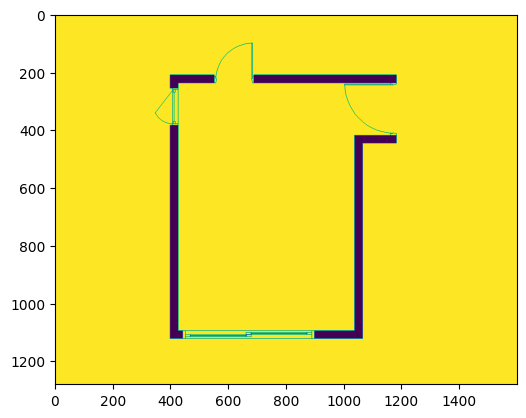

In [39]:
img=gray
rooms, colored_rooms = find_rooms(img.copy())
cv2.imshow("result", colored_rooms)
print(rooms)
cv2.waitKey()
cv2.destroyAllWindows()
plt.imshow(img)

In [40]:
#gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [41]:
gray_rooms = cv2.cvtColor(colored_rooms, cv2.COLOR_BGR2GRAY)


In [42]:
boxes, gray_rooms = precise_boxes(gray_rooms, gray_rooms)

In [43]:
print(type(boxes))

<class 'list'>


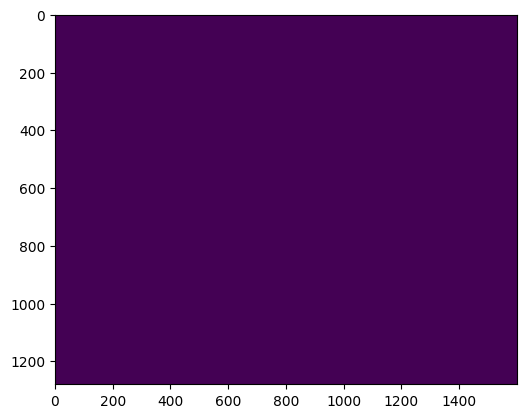

In [44]:
plt.imshow(gray_rooms)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


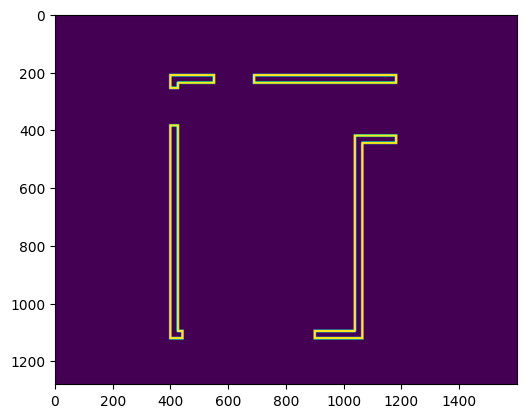

In [45]:
gray =wall_filter(gray)
gray = ~gray

[]


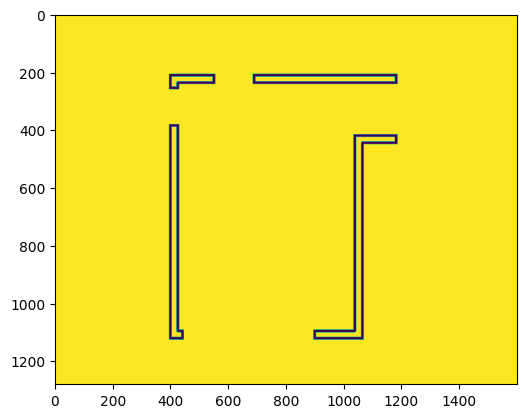

In [46]:
img=gray
rooms, colored_house = find_rooms(img.copy())
cv2.imshow("result", colored_house)
print(rooms)
cv2.waitKey()
cv2.destroyAllWindows()
plt.imshow(img)

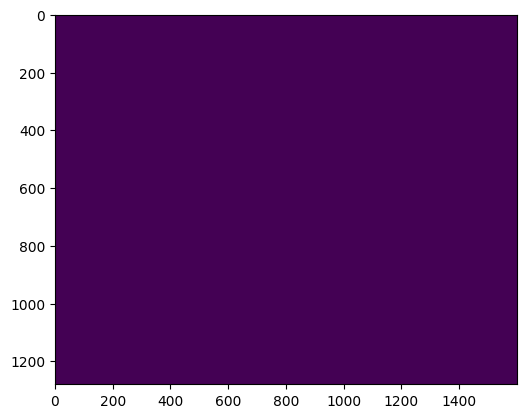

In [47]:
gray_rooms = cv2.cvtColor(colored_house, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_rooms)

In [48]:
boxes, gray_rooms = precise_boxes(gray_rooms, gray_rooms)

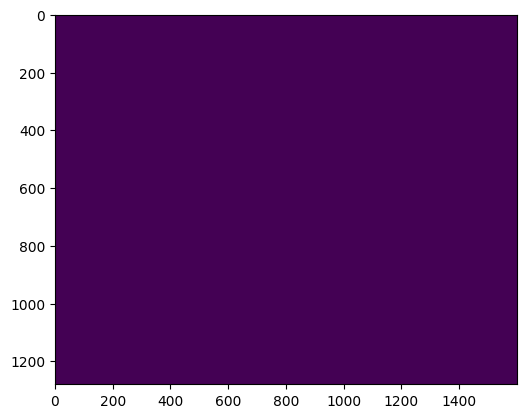

In [49]:
plt.imshow(gray_rooms)

In [50]:
class Room(Generator):
    def __init__(self, gray, path, scale, info=False):
        self.height = (
            const.WALL_HEIGHT - const.ROOM_FLOOR_DISTANCE
        )  # place room slightly above floor
        super().__init__(gray, path, scale, info)

    def generate(self, gray, info=False):
        gray = detect.wall_filter(gray)
        gray = ~gray
        rooms, colored_rooms = detect.find_rooms(gray.copy())
        gray_rooms = cv2.cvtColor(colored_rooms, cv2.COLOR_BGR2GRAY)

        # get box positions for rooms
        boxes, gray_rooms = detect.precise_boxes(gray_rooms, gray_rooms)

        self.verts, self.faces, counter = transform.create_4xn_verts_and_faces(
            boxes=boxes,
            height=self.height,
            scale=self.scale,
            pixelscale=self.pixelscale,
        )

        if info:
            print("Number of rooms detected : ", counter)

        IO.save_to_file(self.path + const.ROOM_VERTS, self.verts, info)
        IO.save_to_file(self.path + const.ROOM_FACES, self.faces, info)

        return self.get_shape(self.verts)


In [51]:
#DOOR_FUNCTIONS

In [52]:
DOOR_MODEL = "Images/Models/Doors/Krisumi Bedroom.png"  # TODO: make dynamic folder solution, to add more doors!
DOOR_WIDTH = 5


WINDOWS_AND_DOORS_FEATURE_N = 10000000
WINDOWS_AND_DOORS_MAX_CORNERS = 4
WINDOWS_AND_DOORS_FEATURE_TRACK_MAX_CORNERS = 30
WINDOWS_AND_DOORS_FEATURE_TRACK_QUALITY = 0.01
WINDOWS_AND_DOORS_FEATURE_TRACK_MIN_DIST = 20

DOOR_ANGLE_HIT_STEP = 30  # Preferably evenly dividable with 360

WINDOWS_COLORED_PIXELS_THRESHOLD = [0.001, 0.00459]
WINDOWS_RESCALE_TO_FIT = 1.05


DETAILS_NOISE_REMOVAL_THRESHOLD = 50
DETAILS_CORNERS_THRESHOLD = 0.01
DETAILS_CLOSING_MAX_LENGTH = 130
DETAILS_GAP_IN_WALL_THRESHOLD = [10, 5000]


In [53]:
def box_center(box):
    """
    Get center position of box
    """
    x, y, w, h = cv2.boundingRect(box)
    return (x + w / 2, y + h / 2)


def euclidean_distance_2d(p1, p2):
    """
    Calculate euclidean distance between two points
    """
    return math.sqrt(abs(math.pow(p1[0] - p2[0], 2) - math.pow(p1[1] - p2[1], 2)))

In [54]:

def cv2_rescale_image(image, factor):
    return cv2.resize(image, None, fx=factor, fy=factor)

In [55]:
def angle_between_vectors_2d(vector1, vector2):
    """
    Get angle between two 2d vectors
    returns radians
    """
    x1, y1 = vector1
    x2, y2 = vector2
    inner_product = x1 * x2 + y1 * y2
    len1 = math.hypot(x1, y1)
    len2 = math.hypot(x2, y2)
    print(len1,len2,inner_product)
    return math.acos(inner_product / (len1 * len2))


In [56]:
def best_matches_with_modulus_angle(match_list):
    """
    This function compare matching matches from orb feature matching,
    by rotating in steps over 360 degrees in order to find the best fit for door rotation.
    """
    # calculate best matches by looking at the most significant feature distances
    index1 = 0
    index2 = 0
    best = math.inf

    for i, _ in enumerate(match_list):
        for j, _ in enumerate(match_list):

            pos1_model = match_list[i][0]
            pos2_model = match_list[j][0]

            pos1_cap = match_list[i][1]
            pos2_cap = match_list[j][1]

            pt1 = (pos1_model[0] - pos2_model[0], pos1_model[1] - pos2_model[1])
            pt2 = (pos1_cap[0] - pos2_cap[0], pos1_cap[1] - pos2_cap[1])

            if pt1 == pt2 or pt1 == (0, 0) or pt2 == (0, 0):
                continue

            ang = math.degrees(angle_between_vectors_2d(pt1, pt2))
            diff = ang % DOOR_ANGLE_HIT_STEP

            if diff < best:
                best = diff
                index1 = i
                index2 = j

    return index1, index2


In [57]:
def rotate_round_origin_vector_2d(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.
    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy


In [58]:
def rect_contains_or_almost_contains_point(pt, box):
    """
    Calculate if a point is within vicinity of a box. Help function.
    """

    x, y, w, h = cv2.boundingRect(box)
    is_inside = x < pt[0] < x + w and y < pt[1] < y + h

    almost_inside = False

    min_dist = 0
    if w < h:
        min_dist = w
    else:
        min_dist = h

    for point in box:
        dist = abs(point[0][0] - pt[0]) + abs(point[0][1] - pt[1])
        if dist <= min_dist:
            almost_inside = True
            break

    return is_inside or almost_inside


In [59]:
def points_are_inside_or_close_to_box(door, box):
    """
    Calculate if a point is within vicinity of a box.
    @parameter Door is a list of points
    @parameter Box is a numpy box
    """
    for point in door:
        if rect_contains_or_almost_contains_point(point, box):
            return True
    return False


In [60]:
def rescale_rect(list_of_rects, scale_factor):
    """
    Rescale box relative to it's center point.
    """

    rescaled_rects = []
    for rect in list_of_rects:
        x, y, w, h = cv2.boundingRect(rect)

        center = (x + w / 2, y + h / 2)

        # Get center diff
        xdiff = abs(center[0] - x)
        ydiff = abs(center[1] - y)

        xshift = xdiff * scale_factor
        yshift = ydiff * scale_factor

        width = 2 * xshift
        height = 2 * yshift

        # upper left
        new_x = x - abs(xdiff - xshift)
        new_y = y - abs(ydiff - yshift)

        # create contour
        contour = np.array(
            [
                [[new_x, new_y]],
                [[new_x + width, new_y]],
                [[new_x + width, new_y + height]],
                [[new_x, new_y + height]],
            ]
        )
        rescaled_rects.append(contour)

    return rescaled_rects


In [61]:
math.inf

inf

In [62]:
def feature_match(img1, img2):
    """
    Feature match models to floorplans in order to distinguish doors from windows.
    Also calculate where doors should exist.
    Compares result with detailed boxes and filter depending on colored pixels to deviate windows, doors and unknowns.
    """
    cap = img1
    model = img2
    # ORB keypoint detector
    orb = cv2.ORB_create(
        nfeatures=WINDOWS_AND_DOORS_FEATURE_N, scoreType=cv2.ORB_FAST_SCORE
    )
    # create brute force  matcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Compute model keypoints and its descriptors
    kp_model, des_model = orb.detectAndCompute(model, None)
    # Compute scene keypoints and its descriptors
    kp_frame, des_frame = orb.detectAndCompute(cap, None)
    # Match frame descriptors with model descriptors
    matches = bf.match(des_model, des_frame)
    # Sort them in the order of their distance
    matches = sorted(matches, key=lambda x: x.distance)

    # --- calculate bounds ---

    # these are important for group matching!
    min_x = math.inf
    min_y = math.inf
    max_x = 0
    max_y = 0

    for mat in matches:
        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx

        # x - columns
        # y - rows
        # Get the coordinates
        (x1, y1) = kp_model[img1_idx].pt

        # bound checks
        if x1 < min_x:
            min_x = x1
        if x1 > max_x:
            max_x = x1

        if y1 < min_y:
            min_y = y1
        if y1 > max_y:
            max_y = y1

    # calculate min/max sizes!
    h = max_y - min_y
    w = max_x - min_x

    # Initialize lists
    list_grouped_matches = []

    # --- Create a list of objects containing matches group on nearby matches ---

    for mat in matches:
        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # Get the coordinates
        # x - columns
        # y - rows
        (x1, y1) = kp_model[img1_idx].pt
        (x2, y2) = kp_frame[img2_idx].pt
        i = 0
        found = False

        for existing_match in list_grouped_matches:
            if (
                abs(existing_match[0][1][0] - x2) < w
                and abs(existing_match[0][1][1] - y2) < h
            ):
                # add to group
                list_grouped_matches[i].append(((int(x1), int(y1)), (int(x2), int(y2))))
                found = True
                break
            # increment
            i += 1

        if not found:
            tmp = list()
            tmp.append(((int(x1), int(y1)), (int(x2), int(y2))))
            list_grouped_matches.append(list(list(list(tmp))))

    # Remove groups with only singles because we cant calculate rotation then!
    list_grouped_matches_filtered = []
    for match_group in list_grouped_matches:
        if len(match_group) >= WINDOWS_AND_DOORS_MAX_CORNERS:
            list_grouped_matches_filtered.append(match_group)

    # find corners of door in model image
    corners = cv2.goodFeaturesToTrack(
        model,
        WINDOWS_AND_DOORS_FEATURE_TRACK_MAX_CORNERS,
        WINDOWS_AND_DOORS_FEATURE_TRACK_QUALITY,
        WINDOWS_AND_DOORS_FEATURE_TRACK_MIN_DIST,
    )
    # Check if corners are found
    if corners is not None:
        corners = np.int8(corners)  # Use np.int0 to properly convert to integer type

        # This is still a little hardcoded but still better than before!
        upper_left = corners[1][0]
        upper_right = corners[0][0]
        down = corners[2][0]

        max_x = 0
        max_y = 0
        min_x = math.inf
        min_y = math.inf

        for cr in corners:
            x1 = cr[0][0]
            y1 = cr[0][1]

            if x1 < min_x:
                min_x = x1
            if x1 > max_x:
                max_x = x1

            if y1 < min_y:
                min_y = y1
            if y1 > max_y:
                max_y = y1

        origin = (int((max_x + min_x) / 2), int((min_y + max_y) / 2))

        list_of_proper_transformed_doors = []
    else:
        raise ValueError("No corners found in the model image. Please check the input image or adjust the parameters.")
        # Calculate position and rotation of doors
    for match in list_grouped_matches_filtered:

        # calculate offsets from points
        index1, index2 = best_matches_with_modulus_angle(match)

        pos1_model = match[index1][0]
        pos2_model = match[index2][0]

        # calculate actual position from offsets with rotation!
        pos1_cap = match[index1][1]
        pos2_cap = match[index2][1]

        pt1 = (pos1_model[0] - pos2_model[0], pos1_model[1] - pos2_model[1])
        pt2 = (pos1_cap[0] - pos2_cap[0], pos1_cap[1] - pos2_cap[1])

        ang = math.degrees(angle_between_vectors_2d(pt1, pt2))

        # rotate door
        new_upper_left = rotate_round_origin_vector_2d(
            origin, upper_left, math.radians(ang)
        )
        new_upper_right = rotate_round_origin_vector_2d(
            origin, upper_right, math.radians(ang)
        )
        new_down = rotate_round_origin_vector_2d(
            origin, down, math.radians(ang)
        )
        new_pos1_model = rotate_round_origin_vector_2d(
            origin, pos1_model, math.radians(ang)
        )

        # calculate scale, and rescale model
        """
        # TODO: fix this scaling problem!
        new_cap1 = rotate(origin, pos1_cap, math.radians(ang))
        new_cap2 = rotate(origin, pos2_cap, math.radians(ang))
        new_model1 = rotate(origin, pos1_model, math.radians(ang))
        new_model2 = rotate(origin, pos2_model, math.radians(ang))

        cap_size = [(new_cap1[0]- new_cap2[0]), (new_cap1[1]- new_cap2[1])]
        model_size = [(new_model1[0]-new_model2[0]),(new_model1[1]-new_model2[1])]
        
        
        if cap_size[1] != 0 or model_size[1] != 0:
            x_scale = abs(cap_size[0]/model_size[0])
            y_scale = abs(cap_size[1]/model_size[1])
            print(x_scale, y_scale)
            scaled_upper_left = scale_model_point_to_origin( origin, new_upper_left,x_scale, y_scale)
            #scaled_upper_right = scale_model_point_to_origin( origin, new_upper_right,x_scale, y_scale)
            #scaled_down = scale_model_point_to_origin( origin, new_down,x_scale, y_scale)
            scaled_pos1_model = scale_model_point_to_origin( origin, new_pos1_model,x_scale, y_scale)
        else:
        """
        scaled_upper_left = new_upper_left
        scaled_upper_right = new_upper_right
        scaled_down = new_down
        scaled_pos1_model = new_pos1_model

        offset = (
            scaled_pos1_model[0] - pos1_model[0],
            scaled_pos1_model[1] - pos1_model[1],
        )

        # calculate dist!
        move_dist = (pos1_cap[0] - pos1_model[0], pos1_cap[1] - pos1_model[1])

        # draw corners!
        moved_new_upper_left = (
            int(scaled_upper_left[0] + move_dist[0] - offset[0]),
            int(scaled_upper_left[1] + move_dist[1] - offset[1]),
        )
        moved_new_upper_right = (
            int(scaled_upper_right[0] + move_dist[0] - offset[0]),
            int(scaled_upper_right[1] + move_dist[1] - offset[1]),
        )
        moved_new_down = (
            int(scaled_down[0] + move_dist[0] - offset[0]),
            int(scaled_down[1] + move_dist[1] - offset[1]),
        )

        list_of_proper_transformed_doors.append(
            [moved_new_upper_left, moved_new_upper_right, moved_new_down]
        )

    gray = wall_filter(img1)
    gray = ~gray  # TODO: is it necessary to convert to grayscale again?
    rooms, colored_rooms = find_rooms(gray.copy())
    doors, colored_doors = find_details(gray.copy())
    gray_rooms = cv2.cvtColor(colored_doors, cv2.COLOR_BGR2GRAY)
    # plt.imshow(colored_doors)
    # get box positions for rooms
    boxes, gray_rooms = precise_boxes(gray_rooms)

    windows = []
    doors = []
    # classify boxes
    # window, door, none
    for box in boxes:

        # is a door inside box?
        is_door = False
        _door = []
        for door in list_of_proper_transformed_doors:

            if points_are_inside_or_close_to_box(
                door, box
            ):  # TODO: match door with only one box, the closest one!
                is_door = True
                _door = door
                break

        if is_door:
            doors.append((_door, box))
            continue

        # is window?
        x, y, w, h = cv2.boundingRect(box)
        cropped = img1[y : y + h, x : x + w]
        # bandpassfilter
        total = np.sum(cropped)
        colored = np.sum(cropped > 0)
        low = WINDOWS_COLORED_PIXELS_THRESHOLD[0]
        high = WINDOWS_COLORED_PIXELS_THRESHOLD[1]

        amount_of_colored = colored / total

        if low < amount_of_colored < high:
            windows.append(box)

    return rescale_rect(windows, WINDOWS_RESCALE_TO_FIT), doors


def find_details(
    img,
    noise_removal_threshold=DETAILS_NOISE_REMOVAL_THRESHOLD,
    corners_threshold=DETAILS_CORNERS_THRESHOLD,
    room_closing_max_length=DETAILS_CLOSING_MAX_LENGTH,
    gap_in_wall_max_threshold=DETAILS_GAP_IN_WALL_THRESHOLD[1],
    gap_in_wall_min_threshold=DETAILS_GAP_IN_WALL_THRESHOLD[0],
):

    """
    I have copied and changed this function some...
    origin from
    https://stackoverflow.com/questions/54274610/crop-each-of-them-using-opencv-python
    @Param img: grey scale image of rooms, already eroded and doors removed etc.
    @Param noise_removal_threshold: Minimal area of blobs to be kept.
    @Param corners_threshold: Threshold to allow corners. Higher removes more of the house.
    @Param room_closing_max_length: Maximum line length to add to close off open doors.
    @Param gap_in_wall_threshold: Minimum number of pixels to identify component as room instead of hole in the wall.
    @Return: rooms: list of numpy arrays containing boolean masks for each detected room
             colored_house: A colored version of the input image, where each room has a random color.
    """
    assert 0 <= corners_threshold <= 1
    # Remove noise left from door removal

    mask = remove_noise(img, noise_removal_threshold)
    img = ~mask

    corners_and_draw_lines(img, corners_threshold, room_closing_max_length)

    img, mask = mark_outside_black(img, mask)

    # Find the connected components in the house
    ret, labels = cv2.connectedComponents(img)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    unique = np.unique(labels)
    details = []
    for label in unique:
        component = labels == label
        if (
            img[component].sum() == 0
            or np.count_nonzero(component) < gap_in_wall_min_threshold
            or np.count_nonzero(component) > gap_in_wall_max_threshold
        ):
            color = 0
        else:
            details.append(component)
            color = np.random.randint(0, 255, size=3)

        img[component] = color

    return details, img


In [63]:
def doors(image_path, scale_factor):
    model = cv2.imread(DOOR_MODEL, 0)
    img = cv2.imread(
        image_path, 0
    )  # TODO: it is not very effective to read image again here!

    img = cv2_rescale_image(img, scale_factor)
    _, doors = feature_match(img, model)
    return doors


In [64]:
def get_point_the_furthest_away(self, door_features, door_box):
        """
        Calculate door point furthest away from doorway
        """
        best_point = None
        dist = 0
        center = box_center(door_box)
        for f in door_features:
            if best_point is None:
                best_point = f
                dist = abs(euclidean_distance_2d(center, f))
            else:
                distance = abs(euclidean_distance_2d(center, f))
                if dist < distance:
                    best_point = f
                    dist = distance
        return best_point

def get_closest_box_point_to_door_point(self, wall_point, box):
        """
        Calculate best point in box to anchor door
        """
        best_point = None
        dist = math.inf

        box_side_points = []
        (x, y, w, h) = cv2.boundingRect(box)

        if w < h:
            box_side_points = [[x + w / 2, y], [x + w / 2, y + h]]
        else:
            box_side_points = [[x, y + h / 2], [x + w, y + h / 2]]

        for fp in box_side_points:
            if best_point is None:
                best_point = fp
                dist = euclidean_distance_2d(wall_point, fp)
            else:
                distance = euclidean_distance_2d(wall_point, fp)
                if distance > dist:
                    best_point = fp
                    dist = distance
        return (int(best_point[0]), int(best_point[1]))

In [72]:
def normalize_2d(normal):
    """
    Calculate normalized point
    """
    mag = magnitude_2d(normal)
    for i, val in enumerate(normal):
        normal[i] = val / mag
    return normal

In [66]:
import matplotlib as plt

In [67]:
# doors(image_path="D:/FloorplanToBlender3d-master/Images/Examples/example6.png",scale_factor=1)

In [68]:
class Door(Generator):
    def __init__(self, gray, path, image_path, scale_factor, scale, info=False):
        self.image_path = image_path
        self.scale_factor = scale_factor
        super().__init__(gray, path, scale, info)

    def get_point_the_furthest_away(self, door_features, door_box):
        """
        Calculate door point furthest away from doorway
        """
        best_point = None
        dist = 0
        center = box_center(door_box)
        for f in door_features:
            if best_point is None:
                best_point = f
                dist = abs(euclidean_distance_2d(center, f))
            else:
                distance = abs(euclidean_distance_2d(center, f))
                if dist < distance:
                    best_point = f
                    dist = distance
        return best_point

    def get_closest_box_point_to_door_point(self, wall_point, box):
        """
        Calculate best point in box to anchor door
        """
        best_point = None
        dist = math.inf

        box_side_points = []
        (x, y, w, h) = cv2.boundingRect(box)

        if w < h:
            box_side_points = [[x + w / 2, y], [x + w / 2, y + h]]
        else:
            box_side_points = [[x, y + h / 2], [x + w, y + h / 2]]

        for fp in box_side_points:
            if best_point is None:
                best_point = fp
                dist = euclidean_distance_2d(wall_point, fp)
            else:
                distance = euclidean_distance_2d(wall_point, fp)
                if distance > dist:
                    best_point = fp
                    dist = distance
        return (int(best_point[0]), int(best_point[1]))

    def generate(self, gray, info=False):

        doors = doors(self.image_path, self.scale_factor)

        door_contours = []
        # get best door shapes!
        for door in doors:
            door_features = door[0]
            door_box = door[1]

            # find door to space point
            space_point = self.get_point_the_furthest_away(door_features, door_box)

            # find best box corner to use as attachment
            closest_box_point = self.get_closest_box_point_to_door_point(
                space_point, door_box
            )

            # Calculate normal
            normal_line = [
                space_point[0] - closest_box_point[0],
                space_point[1] - closest_box_point[1],
            ]

            # Normalize point
            normal_line = normalize_2d(normal_line)

            # Create door contour
            x1 = closest_box_point[0] + normal_line[1] * DOOR_WIDTH
            y1 = closest_box_point[1] - normal_line[0] * DOOR_WIDTH

            x2 = closest_box_point[0] - normal_line[1] * DOOR_WIDTH
            y2 = closest_box_point[1] + normal_line[0] * DOOR_WIDTH

            x4 = space_point[0] + normal_line[1] * DOOR_WIDTH
            y4 = space_point[1] - normal_line[0] * DOOR_WIDTH

            x3 = space_point[0] - normal_line[1] * DOOR_WIDTH
            y3 = space_point[1] + normal_line[0] * DOOR_WIDTH

            c1 = [int(x1), int(y1)]
            c2 = [int(x2), int(y2)]
            c3 = [int(x3), int(y3)]
            c4 = [int(x4), int(y4)]

            door_contour = np.array([[c1], [c2], [c3], [c4]], dtype=np.int32)
            door_contours.append(door_contour)

        if const.DEBUG_DOOR:
            print("Showing DEBUG door. Press any key to continue...")
            img = draw.contoursOnImage(gray, door_contours)
            draw.image(img)

        # Create verts for door

        self.verts, self.faces, door_amount = transform.create_nx4_verts_and_faces(
            boxes=door_contours,
            height=self.height,
            scale=self.scale,
            pixelscale=self.pixelscale,
        )

        if info:
            print("Doors created : ", int(door_amount / 4))

        IO.save_to_file(self.path + "door_vertical_verts", self.verts, info)
        IO.save_to_file(self.path + "door_vertical_faces", self.faces, info)

        self.verts, self.faces, door_amount = transform.create_4xn_verts_and_faces(
            boxes=door_contours,
            height=self.height,
            scale=self.scale,
            pixelscale=self.pixelscale,
            ground=True,
            ground_height=const.WALL_GROUND,
        )

        # One solution to get data to blender is to write and read from file.
        IO.save_to_file(self.path + "door_horizontal_verts", self.verts, info)
        IO.save_to_file(self.path + "door_horizontal_faces", self.faces, info)

        return self.get_shape(self.verts)

14.212670403551895 13.892443989449804 31
19.72308292331602 26.832815729997478 -36
85.56284240252891 70.09279563550022 253
10.0 17.0 26
54.48853090330111 55.154328932550705 117
14.422205101855956 23.430749027719962 -36
26.40075756488817 12.206555615733702 -13
39.698866482558415 25.495097567963924 16
67.20863039818622 42.44997055358225 -5
95.4829827770373 68.62215385719105 57
3.1622776601683795 4.242640687119285 -6
24.839484696748443 20.615528128088304 -9
30.01666203960727 12.206555615733702 -32
46.75467891024384 84.50443775329198 601
8.06225774829855 8.94427190999916 -4
78.49203781276162 112.89375536317321 1688
86.97700845625813 88.86506625215557 737
30.610455730027933 30.4138126514911 177
62.289646009589745 72.91776189653656 426
36.235341863986875 53.03772242470448 -538
112.60994627474076 38.91015291668744 1665
82.73451516749222 77.89736837660179 406
34.0 75.82216034906945 -910
6.4031242374328485 89.49860334105779 117
102.59142264341595 107.41508273980894 1365
75.69015788066504 65.7647

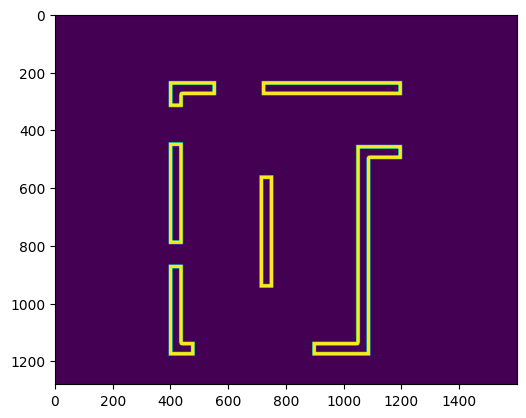

In [71]:
doors = doors(image_path="D:/FloorplanToBlender3d-master/Images/Examples/BedroomOp1.png",scale_factor=1)

door_contours = []
# get best door shapes!
for door in doors:
    door_features = door[0]
    door_box = door[1]

    # find door to space point
    space_point = Door.get_point_the_furthest_away(door_features, door_box)

    # find best box corner to use as attachment
    closest_box_point = Door.get_closest_box_point_to_door_point(
        space_point, door_box
    )

    # Calculate normal
    normal_line = [
        space_point[0] - closest_box_point[0],
        space_point[1] - closest_box_point[1],
    ]

    # Normalize point
    normal_line = normalize_2d(normal_line)

    # Create door contour
    x1 = closest_box_point[0] + normal_line[1] * DOOR_WIDTH
    y1 = closest_box_point[1] - normal_line[0] * DOOR_WIDTH

    x2 = closest_box_point[0] - normal_line[1] * DOOR_WIDTH
    y2 = closest_box_point[1] + normal_line[0] * DOOR_WIDTH

    x4 = space_point[0] + normal_line[1] * DOOR_WIDTH
    y4 = space_point[1] - normal_line[0] * DOOR_WIDTH

    x3 = space_point[0] - normal_line[1] * DOOR_WIDTH
    y3 = space_point[1] + normal_line[0] * DOOR_WIDTH

    c1 = [int(x1), int(y1)]
    c2 = [int(x2), int(y2)]
    c3 = [int(x3), int(y3)]
    c4 = [int(x4), int(y4)]

    door_contour = np.array([[c1], [c2], [c3], [c4]], dtype=np.int32)
    door_contours.append(door_contour)


In [ ]:
door_contours

[]